In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [8]:
# Arxiv and Wiki tools

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun 
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars=250)
arxiv = ArxivQueryRun(api_wrapper = api_wrapper_arxiv)
print(arxiv)

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars=500)
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)
print(wiki)

api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000)
api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\Code\\Python\\agentic-ai-app\\venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)


In [9]:
# Tavily tool for web search 

from langchain_community.tools.tavily_search import TavilySearchResults 

tavily = TavilySearchResults()
tavily.invoke("What is the current AI news in Oct 21, 2025?")

C:\Users\indra\AppData\Local\Temp\ipykernel_18484\1043150669.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


[{'title': 'Iron Mountain launches updates to its InSight DXP platform',
  'url': 'https://www.ironmountain.com/about-us/media-center/press-releases/2025/october/iron-mountain-insight-dxp-platform',
  'content': '# Iron Mountain launches updates to its InSight DXP platform - helping enterprises unlock more actionable intelligence with AI\n\nIron Mountain (NYSE: IRM), a global leader in information management services, today announced the latest version of its Iron Mountain InSight® DXP platform, engineered to transform passive assets into active intelligence.\n\nOctober 21, 2025',
  'score': 0.8332299},
 {'title': 'Ignite: AI - October 21 | Los Angeles - Insights Association',
  'url': 'https://www.insightsassociation.org/Events/Ignite-AI-October-21-Los-Angeles',
  'content': "Insights Association\nInsights Association\nInsights Association\n\nImportant Notice: The Insights Association\ndoes not sell attendee lists or\nauthorize third-party vendors to book hotel rooms or manage event r

In [11]:
tools = [arxiv, wiki, tavily]

In [25]:
from langchain_groq import ChatGroq 

llm = ChatGroq(model="openai/gpt-oss-20b")
llm_with_tools = llm.bind_tools(tools)

In [27]:
from langchain_core.messages import HumanMessage

llm_with_tools.invoke([
    HumanMessage(content="Attention is all you need")
]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Attention Is All You Need paper summary'},
  'id': 'fc_12cfbc6e-0590-416c-b903-0299e2ce75e0',
  'type': 'tool_call'}]

#### LangGraph multiple tools

In [24]:
# State schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [28]:
# Node definition 
def tool_calling_llm(state: State):
    return {"messages": llm_with_tools.invoke(state["messages"])}

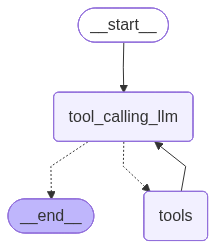

In [49]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Build Graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
# builder.add_edge("tools", END)
builder.add_edge("tools", "tool_calling_llm")

# graph = builder.compile()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {
    "configurable": {"thread_id": 2}
}

In [54]:
from pprint import pprint

messages = graph.invoke({
    "messages": HumanMessage(content="What is 52+77?")
}, config=config)

messages = graph.invoke({
    "messages": HumanMessage(content="Add 10 to it")
}, config=config)

for msg in messages["messages"]:
    pprint(msg)

HumanMessage(content='What is 52+77?', additional_kwargs={}, response_metadata={}, id='5e613747-4924-426d-9493-44221a80fa21')
AIMessage(content='52\u202f+\u202f77\u202f=\u202f**129**', additional_kwargs={'reasoning_content': 'The user asks a simple arithmetic: 52+77. The sum is 129. No need for external tools.'}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 292, 'total_tokens': 337, 'completion_time': 0.044033845, 'prompt_time': 0.017912151, 'queue_time': 0.048776539, 'total_time': 0.061945996}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_3d587a02fb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--2a7ec28b-0003-44eb-8952-8f591ab10020-0', usage_metadata={'input_tokens': 292, 'output_tokens': 45, 'total_tokens': 337})
HumanMessage(content='Add 10 to it', additional_kwargs={}, response_metadata={}, id='e36a61e8-18fb-42dc-90e2-ef3eaf67ef46')
AIMessage(content='139', additional_kwargs={'reasoning_content': 